# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'C:\\Users\\HP\\Documents\\GitHub\\02_segbot\\ae353_segbot.py'>

### Pybullet Simulator

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [60]:
simulator = ae353_segbot.Simulator(
    display=False,
    width=480,
    height=320,
    bumpy=True,
)

### Construction of $f$

In [61]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

In [62]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)


# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Define variables (with a flag to indicate they are all real numbers — this helps simplify):

In [63]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

Compute equations of motion, excluding lateral and heading errors (see [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses)):

In [64]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

Compute full equations of motion:

In [65]:
### Compute full equations of motion (define right side of ODEs):
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

## Replace second-order ODE with two first-order ODEs
f = f.row_insert(4,sym.Matrix([[thetadot]]))

## Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)
f

Matrix([
[                                                                                                                                                                           v*sin(e_h)],
[                                                                                                                                                                                    w],
[        -(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                             thetadot],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*t

Display the vector-valued function $f$ for which the equations of motion can be written as

$$\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \ddot{\theta} \\ \dot{\theta} \end{bmatrix} = f(e_\text{lateral}, e_\text{heading}, v, w, \theta, \dot{\theta}, \tau_R, \tau_L)$$

In [ ]:
f

\left[\begin{matrix}v \sin{\left(e_{h} \right)}\\w\\- \frac{1200 \tau_{L} + 1200 \tau_{R} + 1404 \left(v_{2}^{2} + w^{2}\right) \sin{\left(\theta \right)} + \frac{65 \left(50 \tau_{L} + 50 \tau_{R} - 39 w^{2} \sin{\left(2 \theta \right)} - 900 \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)}}{2}}{5850 \cos^{2}{\left(\theta \right)} - 6084}\\\frac{32 \left(- 875 \tau_{L} + 875 \tau_{R} - 2925 v w \sin{\left(\theta \right)} - 1443 v_{2} w \sin{\left(2 \theta \right)}\right)}{13 \left(3120 \sin^{2}{\left(\theta \right)} + 2051\right)}\\\frac{5 \left(4225 \tau_{L} + 4225 \tau_{R} - \frac{6591 w^{2} \sin{\left(2 \theta \right)}}{2} + 30 \left(100 \tau_{L} + 100 \tau_{R} + 117 \left(v_{2}^{2} + w^{2}\right) \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)} - 76050 \sin{\left(\theta \right)}\right)}{702 \left(25 \cos^{2}{\left(\theta \right)} - 26\right)}\\v_{2}\end{matrix}\right]

In [66]:
def get_model(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le):
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([e_l, e_h, v, w, theta, thetadot])
    
    B_sym = f.jacobian([tau_R, tau_L])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], A_sym)
    
    B_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], B_sym)
    
    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le).astype(float)
    
    B = B_num(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le).astype(float)
    
    return A, B


Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [67]:
class Controller:
    def __init__(self, K, e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.ve = ve
        self.we = we
        self.thetae = thetae
        self.thetadote = thetadote
        self.tau_Re = tau_Re
        self.tau_Le = tau_Le
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        x = np.array([lateral_error - self.e_le, heading_error - self.e_he, forward_speed - self.ve, turning_rate - self.we, pitch_angle - self.thetae, pitch_rate - self.thetadote])
        u = -self.K@x
        tau_R = u[0]
        tau_L = u[1]
        right_wheel_torque = tau_R
        left_wheel_torque = tau_L
        
        return right_wheel_torque, left_wheel_torque

In [83]:
def get_data(
    simulator, 
    e_le,
    e_he,
    ve,
    we,
    thetae,
    thetadote,
    tau_Re,
    tau_Le,
    K,
    vi, 
    e_li, 
    e_hi, 
    thetai, 
    svi,
    max_time=600.0
):
    
    # Create controller
    controller = Controller(
        K,
        e_le,
        e_he,
        ve,
        we,
        thetae,
        thetadote,
        tau_Re,
        tau_Le
    )

    # Reset simulator with initial conditions [v_i, e_l_i, e_h_i, theta_i, sv_i]
    simulator.reset(
        initial_speed=vi, 
        initial_lateral_error=e_li, 
        initial_heading_error=e_hi,
        initial_pitch=thetai,
        station_velocity=svi 
    )


    # Reset controller
    controller.reset()
    
    # Choose a camera view: [ camera_sideview(), camera_backview(), camera_wideview() ]
    simulator.camera_backview()

    # Run simulator
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=max_time,    # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )

    # Return data
    return data

In [84]:
e_le= 0.0
e_he = 0.0
ve = 1.2
thetae = 0.
thetadote = 0.
we = 0.
v2e = 0.
tau_Re = 0.
tau_Le = 0.


f_num = sym.lambdify([e_l, e_h, w, theta, thetadot, tau_R, tau_L], f)
f_eq = f_num(e_le, e_he, we, thetae, thetadote, tau_Re, tau_Le)

# Convert numerical array from type 'object' to floats
f_eq = np.array(f_eq).astype(np.float64)

# raise exception if f != 0
if not np.allclose(f_eq, 0.):
    raise Exception('equilibrium point is invalid')


In [85]:
A, B = get_model(
    e_le,
    e_he,
    ve,
    we,
    thetae,
    thetadote,
    tau_Re,
    tau_Le
)
print(A.tolist())
print(A.shape)

print(B.tolist())

[[0.0, 1.2, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -125.0, 0.0], [0.0, 0.0, -0.0, -0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, -0.0, 541.6666666666666, -0.0]]
(6, 6)
[[0.0, 0.0], [0.0, 0.0], [12.072649572649572, 12.072649572649572], [1.0501443948542923, -1.0501443948542923], [0.0, 0.0], [-51.46011396011396, -51.46011396011396]]


Create an instance of the controller.

### Define a function for generating set of Q and R matrices
Simulating Q and R matrices for testing purposes

In [86]:
e_le= 0.0
e_he = 0.0
ve = 1.2
thetae = 0.
we = 0.
thetadote = 0.
tau_Re = 0.
tau_Le = 0.


vi = 1.0
e_li = 0.
e_hi = 0.
thetai = -0.
svi = -0.5

# q1 = np.linspace(1000, 200000)
# print(q1.shape)

# end specifies the upper limit on q1

# Generates list of possible Q and R matrices
def generate_lqrmatrices(end, num):
    Q_list = []
    R_list = []
    q1 = np.linspace(1000, end, num)
    q2 = np.linspace(0.1, 500, num)
    q3 = np.linspace(0.1, 1, num)
    q4 = np.linspace(0.1, 1, num)
    q5 = np.linspace(0.1, 1, num)
    q6 = np.linspace(0.1, 5, num)
    r1 = np.linspace(0.1, 2, num)
    r3 = np.linspace(0.1, 2, num)
    for i in range(0,len(q1)):
        Q = np.diag([q1[i], q2[i], q3[i],q4[i], q5[i], q6[i]])
        Q_list.append(Q)
        R = np.diag([r1[i], r3[i]])
        R_list.append(R)
    
    return Q_list, R_list
# generate_lqrmatrices(100)[1]
# Q = np.diag([100, 0.01, 0.01,0.01,0.01, 0.01])
# R = np.diag([3, 3])
# P = linalg.solve_continuous_are(A, B, Q, R)
# K = linalg.inv(R) @ B.T @ P
# K

In [75]:
# Generates list of possible K matrices from 

def generate_gains(Q_list, R_list):
    K_list = []   # total K list
    K_working = []
    P_list = []
    theta = []
    heading = []
    lateral = []
    velocity = []
    final_Q = []
    final_R = []
    for i in range(0, len(Q_list)):
        P_list.append(linalg.solve_continuous_are(A, B, Q_list[i], R_list[i]))
        K_list.append((linalg.inv(R_list[i]) @ B.T @ P_list[i]))
        data = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K_list[i], vi,e_li, e_hi,thetai,svi,max_time=65.0)
        theta.append(data['pitch_angle'])
        heading.append(data['heading_error'])
        lateral.append(data['lateral_error'])
        velocity.append(data['forward_speed'])
        
        if (np.all(velocity[i]) > 0.8) == True:
            if ((np.all(theta[i]) < 0.1) and (np.all(heading[i]) < 0.1) and (np.all(lateral[i]) < 0.1)) == True:
                K_working.append(K_list[i])
                final_Q.append(Q_list[i])
                final_R.append(R_list[i])
            
    return [K_working, final_Q, final_R]

# def write_to_file(K, Q, R):
#     with open('D:/text_file.txt', 'w') as f:
#     f.write(K_working)
    
    
        
 
# generate_lqrmatrices(20000)[1]
# generate_lqrmatrices(20000)[0]

K = generate_gains(generate_lqrmatrices(10000, 20)[0], generate_lqrmatrices(10000, 20)[1])
K

[[array([[ 70.71067812,  30.34047165,  -0.70710678,   5.42141256,
          -10.84946636,  -1.0251626 ],
         [-70.71067812, -30.34047165,  -0.70710678,  -5.42141256,
          -10.84946636,  -1.0251626 ]]),
  array([[ 60.69769787,  28.90259946,  -0.60697698,   5.2811856 ,
          -10.83973177,  -1.2033681 ],
         [-60.69769787, -28.90259946,  -0.60697698,  -5.2811856 ,
          -10.83973177,  -1.2033681 ]]),
  array([[ 56.97029081,  28.32326581,  -0.56970291,   5.22449914,
          -10.82977875,  -1.25375571],
         [-56.97029081, -28.32326581,  -0.56970291,  -5.22449914,
          -10.82977875,  -1.25375571]]),
  array([[ 55.01196042,  28.00897353,  -0.5501196 ,   5.19366697,
          -10.82353574,  -1.27757571],
         [-55.01196042, -28.00897353,  -0.5501196 ,  -5.19366697,
          -10.82353574,  -1.27757571]]),
  array([[ 53.80275868,  27.81144015,  -0.53802759,   5.17425527,
          -10.81937047,  -1.29145144],
         [-53.80275868, -27.81144015,  -0.53802

In [81]:
# Working lqr + K

K = np.array([[ 50.06920419,  27.18452469,  -0.50069204,   5.11245109,
          -10.80516975,  -1.33059646],
         [-50.06920419, -27.18452469,  -0.50069204,  -5.11245109,
          -10.80516975,  -1.33059646]])
Q = np.array([[7.63157895e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.68447368e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 7.63157895e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.63157895e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          7.63157895e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.71052632e+00]])

R = np.array([[1.5, 0. ],
         [0. , 1.5]])



Reset the controller.

Choose a camera view from the following options:
* `camera_sideview()`
* `camera_backview()`
* `camera_wideview()`

In [18]:
simulator.camera_backview()

Run the simulator.

In [89]:
K = np.array([[ 50.43668951,  27.24738429,  -0.5043669 ,   5.11866268,
          -10.80665104,  -1.32697914],
         [-50.43668951, -27.24738429,  -0.5043669 ,  -5.11866268,
          -10.80665104,  -1.32697914]])
data = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,thetai,svi,max_time=175.0)



# data = simulator.run(
#     controller,           # <-- required (an instance of your Controller class)
#     max_time=500.,         # <-- optional (how long you want to run the simulation in seconds)
#     data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
#     video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
# )

Get, show, and save a snapshot of the simulation after the last time step.

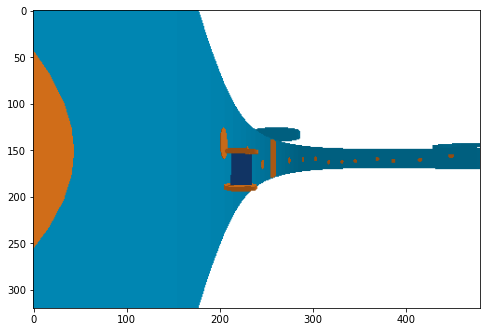

In [90]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

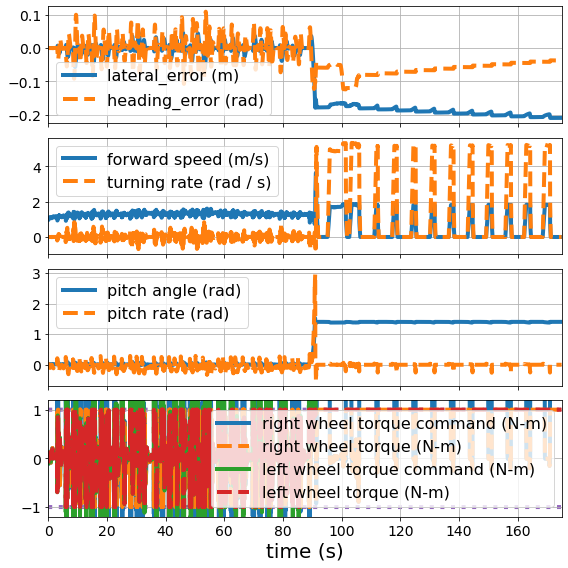

In [91]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

In [ ]:
Q = [[9.52631579e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.73689474e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 9.52631579e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.52631579e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.52631579e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 4.74210526e+00]]



In [ ]:
[[array([[ 70.71067812,  30.34047165,  -0.70710678,   5.42141256,
          -10.84946636,  -1.0251626 ],
         [-70.71067812, -30.34047165,  -0.70710678,  -5.42141256,
          -10.84946636,  -1.0251626 ]]),
  array([[ 60.69769787,  28.90259946,  -0.60697698,   5.2811856 ,
          -10.83973177,  -1.2033681 ],
         [-60.69769787, -28.90259946,  -0.60697698,  -5.2811856 ,
          -10.83973177,  -1.2033681 ]]),
  array([[ 56.97029081,  28.32326581,  -0.56970291,   5.22449914,
          -10.82977875,  -1.25375571],
         [-56.97029081, -28.32326581,  -0.56970291,  -5.22449914,
          -10.82977875,  -1.25375571]]),
  array([[ 55.01196042,  28.00897353,  -0.5501196 ,   5.19366697,
          -10.82353574,  -1.27757571],
         [-55.01196042, -28.00897353,  -0.5501196 ,  -5.19366697,
          -10.82353574,  -1.27757571]]),
  array([[ 53.80275868,  27.81144015,  -0.53802759,   5.17425527,
          -10.81937047,  -1.29145144],
         [-53.80275868, -27.81144015,  -0.53802759,  -5.17425527,
          -10.81937047,  -1.29145144]]),
  array([[ 52.98129428,  27.67572115,  -0.52981294,   5.16090178,
          -10.81641411,  -1.30053256],
         [-52.98129428, -27.67572115,  -0.52981294,  -5.16090178,
          -10.81641411,  -1.30053256]]),
  array([[ 52.38664813,  27.57670071,  -0.52386648,   5.15115029,
          -10.81421271,  -1.30693718],
         [-52.38664813, -27.57670071,  -0.52386648,  -5.15115029,
          -10.81421271,  -1.30693718]]),
  array([[ 51.93619567,  27.50125579,  -0.51936196,   5.14371536,
          -10.81251182,  -1.3116962 ],
         [-51.93619567, -27.50125579,  -0.51936196,  -5.14371536,
          -10.81251182,  -1.3116962 ]]),
  array([[ 51.58312431,  27.44185746,  -0.51583124,   5.13785857,
          -10.81115901,  -1.31537146],
         [-51.58312431, -27.44185746,  -0.51583124,  -5.13785857,
          -10.81115901,  -1.31537146]]),
  array([[ 51.2989176 ,  27.39387577,  -0.51298918,   5.13312537,
          -10.81005775,  -1.31829522],
         [-51.2989176 , -27.39387577,  -0.51298918,  -5.13312537,
          -10.81005775,  -1.31829522]]),
  array([[ 51.06520834,  27.3543064 ,  -0.51065208,   5.12922059,
          -10.80914403,  -1.32067654],
         [-51.06520834, -27.3543064 ,  -0.51065208,  -5.12922059,
          -10.80914403,  -1.32067654]]),
  array([[ 50.86963041,  27.32111453,  -0.5086963 ,   5.12594413,
          -10.80837382,  -1.32265353],
         [-50.86963041, -27.32111453,  -0.5086963 ,  -5.12594413,
          -10.80837382,  -1.32265353]]),
  array([[ 50.70355217,  27.29287284,  -0.50703552,   5.12315559,
          -10.80771584,  -1.32432109],
         [-50.70355217, -27.29287284,  -0.50703552,  -5.12315559,
          -10.80771584,  -1.32432109]]),
  array([[ 50.5607652 ,  27.26855047,  -0.50560765,   5.12075349,
          -10.80714725,  -1.32574658],
         [-50.5607652 , -27.26855047,  -0.50560765,  -5.12075349,
          -10.80714725,  -1.32574658]]),
  array([[ 50.43668951,  27.24738429,  -0.5043669 ,   5.11866268,
          -10.80665104,  -1.32697914],
         [-50.43668951, -27.24738429,  -0.5043669 ,  -5.11866268,
          -10.80665104,  -1.32697914]]),
  array([[ 50.32787237,  27.22879725,  -0.50327872,   5.11682633,
          -10.80621421,  -1.32805544],
         [-50.32787237, -27.22879725,  -0.50327872,  -5.11682633,
          -10.80621421,  -1.32805544]]),
  array([[ 50.23166147,  27.21234492,  -0.50231661,   5.11520062,
          -10.80582672,  -1.32900343],
         [-50.23166147, -27.21234492,  -0.50231661,  -5.11520062,
          -10.80582672,  -1.32900343]]),
  array([[ 50.14598571,  27.19767945,  -0.50145986,   5.11375129,
          -10.80548067,  -1.32984475],
         [-50.14598571, -27.19767945,  -0.50145986,  -5.11375129,
          -10.80548067,  -1.32984475]]),
  array([[ 50.06920419,  27.18452469,  -0.50069204,   5.11245109,
          -10.80516975,  -1.33059646],
         [-50.06920419, -27.18452469,  -0.50069204,  -5.11245109,
          -10.80516975,  -1.33059646]]),
  array([[ 50.        ,  27.17265861,  -0.5       ,   5.11127813,
          -10.80488888,  -1.33127213],
         [-50.        , -27.17265861,  -0.5       ,  -5.11127813,
          -10.80488888,  -1.33127213]])

Q = array([[1.e+03, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 1.e-01, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 1.e-01, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 1.e-01, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-01, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-01]]),
  array([[1.47368421e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.64105263e+01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.47368421e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.47368421e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.47368421e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.57894737e-01]]),
  array([[1.94736842e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 5.27210526e+01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.94736842e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.94736842e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.94736842e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 6.15789474e-01]]),
  array([[2.42105263e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 7.90315789e+01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 2.42105263e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.42105263e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.42105263e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 8.73684211e-01]]),
  array([[2.89473684e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.05342105e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 2.89473684e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.89473684e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.89473684e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.13157895e+00]]),
  array([[3.36842105e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.31652632e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 3.36842105e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36842105e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          3.36842105e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.38947368e+00]]),
  array([[3.84210526e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.57963158e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 3.84210526e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.84210526e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          3.84210526e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.64736842e+00]]),
  array([[4.31578947e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.84273684e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.31578947e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.31578947e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          4.31578947e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.90526316e+00]]),
  array([[4.78947368e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.10584211e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.78947368e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.78947368e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          4.78947368e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 2.16315789e+00]]),
  array([[5.26315789e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.36894737e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.26315789e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.26315789e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.26315789e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 2.42105263e+00]]),
  array([[5.73684211e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.63205263e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.73684211e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.73684211e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.73684211e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 2.67894737e+00]]),
  array([[6.21052632e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.89515789e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.21052632e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21052632e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          6.21052632e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 2.93684211e+00]]),
  array([[6.68421053e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.15826316e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.68421053e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.68421053e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          6.68421053e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.19473684e+00]]),
  array([[7.15789474e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.42136842e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 7.15789474e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.15789474e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          7.15789474e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.45263158e+00]]),
  array([[7.63157895e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.68447368e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 7.63157895e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.63157895e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          7.63157895e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.71052632e+00]]),
  array([[8.10526316e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.94757895e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 8.10526316e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.10526316e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          8.10526316e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.96842105e+00]]),
  array([[8.57894737e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.21068421e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 8.57894737e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.57894737e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          8.57894737e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 4.22631579e+00]]),
  array([[9.05263158e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.47378947e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 9.05263158e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.05263158e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.05263158e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 4.48421053e+00]]),
  array([[9.52631579e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.73689474e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 9.52631579e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.52631579e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          9.52631579e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 4.74210526e+00]]),
  array([[1.e+04, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 5.e+02, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 1.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e+00]])]
     
R = array([[0.1, 0. ],
         [0. , 0.1]]),
  array([[0.2, 0. ],
         [0. , 0.2]]),
  array([[0.3, 0. ],
         [0. , 0.3]]),
  array([[0.4, 0. ],
         [0. , 0.4]]),
  array([[0.5, 0. ],
         [0. , 0.5]]),
  array([[0.6, 0. ],
         [0. , 0.6]]),
  array([[0.7, 0. ],
         [0. , 0.7]]),
  array([[0.8, 0. ],
         [0. , 0.8]]),
  array([[0.9, 0. ],
         [0. , 0.9]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1.1, 0. ],
         [0. , 1.1]]),
  array([[1.2, 0. ],
         [0. , 1.2]]),
  array([[1.3, 0. ],
         [0. , 1.3]]),
  array([[1.4, 0. ],
         [0. , 1.4]]),
  array([[1.5, 0. ],
         [0. , 1.5]]),
  array([[1.6, 0. ],
         [0. , 1.6]]),
  array([[1.7, 0. ],
         [0. , 1.7]]),
  array([[1.8, 0. ],
         [0. , 1.8]]),
  array([[1.9, 0. ],
         [0. , 1.9]]),
  array([[2., 0.],
         [0., 2.]])]

In [ ]:
[[array([[ 53.59422008,  26.77830821,  -0.5359422 ,   5.07807818,
          -10.72717866,  -0.84092477],
         [-53.59422008, -26.77830821,  -0.5359422 ,  -5.07807818,
          -10.72717866,  -0.84092477]]),
  array([[ 52.22329679,  26.47531004,  -0.52223297,   5.04815226,
          -10.71866362,  -0.82680976],
         [-52.22329679, -26.47531004,  -0.52223297,  -5.04815226,
          -10.71866362,  -0.82680976]]),
  array([[ 51.44957554,  26.3030519 ,  -0.51449576,   5.0310821 ,
          -10.71394241,  -0.81889499],
         [-51.44957554, -26.3030519 ,  -0.51449576,  -5.0310821 ,
          -10.71394241,  -0.81889499]]),
  array([[ 50.95246654,  26.19189544,  -0.50952467,   5.0200446 ,
          -10.71094126,  -0.81382999],
         [-50.95246654, -26.19189544,  -0.50952467,  -5.0200446 ,
          -10.71094126,  -0.81382999]]),
  array([[ 50.3508815 ,  26.056869  ,  -0.50350881,   5.00661309,
          -10.70734304,  -0.80772205],
         [-50.3508815 , -26.056869  ,  -0.50350881,  -5.00661309,
          -10.70734304,  -0.80772205]]),
  array([[ 50.        ,  25.9778545 ,  -0.5       ,   4.99874104,
          -10.70526136,  -0.80417061],
         [-50.        , -25.9778545 ,  -0.5       ,  -4.99874104,
          -10.70526136,  -0.80417061]])],
 [array([[3.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 6.67444444e+01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 3.00000000e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000000e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          3.00000000e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.00000000e-01]]),
  array([[4.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.00066667e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.00000000e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.00000000e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          4.00000000e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 4.00000000e-01]]),
  array([[5.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.33388889e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.00000000e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00000000e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.00000000e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 5.00000000e-01]]),
  array([[6.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.66711111e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.00000000e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.00000000e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          6.00000000e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 6.00000000e-01]]),
  array([[8.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.33355556e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 8.00000000e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.00000000e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          8.00000000e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 8.00000000e-01]]),
  array([[1.e+04, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 3.e+02, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 1.e+00, 0.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00, 0.e+00],
         [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00]])],
 [array([[0.52222222, 0.        ],
         [0.        , 0.52222222]]),
  array([[0.73333333, 0.        ],
         [0.        , 0.73333333]]),
  array([[0.94444444, 0.        ],
         [0.        , 0.94444444]]),
  array([[1.15555556, 0.        ],
         [0.        , 1.15555556]]),
  array([[1.57777778, 0.        ],
         [0.        , 1.57777778]]),
  array([[2., 0.],
         [0., 2.]])]]